In [1]:
import pandas as pd  #pandas does things with matrixes
import numpy as np #used for sorting a matrix
import matplotlib.pyplot as plt #matplotlib is used for plotting data
import matplotlib.ticker as ticker #used for changing tick spacing
import datetime as dt #used for dates
import matplotlib.dates as mdates #used for dates, in a different way
import os #used for changes of directory
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler # It scales the data between 0 and 1
import sys
sys.path.append('../')
from utils import simple_plot, simple_plot_by_date, hit_count

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F

In [2]:
# Device configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
dataset_1yr = pd.read_csv("../../Data/all_stocks_5yr.csv")
dataset_1yr.head()

# Changing the date column to the datetime format (best format to work with time series)
dataset_1yr['Date'] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dataset_1yr['Date']]

dataset_1yr.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [3]:
# Assigning a mid price column with the mean of the Highest and Lowest values

dataset_1yr['Mid'] = (dataset_1yr['High'] + dataset_1yr['Low'])/2
dataset_1yr.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [4]:
# Getting rid of null columns

missing_data = pd.DataFrame(dataset_1yr.isnull().sum()).T
print(missing_data)

for index, column in enumerate(missing_data.columns):
    if missing_data.loc[0][index] != 0:
        dataset_1yr = dataset_1yr.drop(dataset_1yr.loc[dataset_1yr[column].isnull()].index)
        
missing_data = pd.DataFrame(dataset_1yr.isnull().sum()).T
print(missing_data)

   Date  Open  High  Low  Close  Volume  Name  Mid
0     0   384   208  227      0     406     0  358
   Date  Open  High  Low  Close  Volume  Name  Mid
0     0     0     0    0      0       0     0    0


In [5]:
# Let's analyze 3M stocks a bit deeper

MMM_stocks = dataset_1yr[dataset_1yr['Name'] == 'MMM']

MMM_stocks.head()

,Date,Open,High,Low,Close,Volume,Name,Mid
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM,92.165
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM,92.255
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM,92.340
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM,93.040
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM,93.945


In [6]:
# Creating a percent change column related to the closing price

percent_change_closing_price = MMM_stocks['Close'].pct_change()
percent_change_closing_price.fillna(0, inplace=True)
MMM_stocks['PC_change'] = pd.DataFrame(percent_change_closing_price)

# As we want to predict the closing price, let's add the target column as the close price shifted by 1

MMM_stocks['Target'] = MMM_stocks['Close'].shift(-1)

MMM_stocks = MMM_stocks.drop(0, axis = 0)
MMM_stocks = MMM_stocks.drop('Name', axis = 1)
MMM_stocks = MMM_stocks.drop('Date', axis = 1)

MMM_stocks.head()

,Open,High,Low,Close,Volume,Mid,PC_change,Target
1,92.36,92.50,92.01,92.30,1843476.0,92.255,-0.001082,92.54
2,92.00,92.74,91.94,92.54,1983395.0,92.340,0.002600,93.74
3,92.75,93.87,92.21,93.74,3395145.0,93.040,0.012967,94.24
4,93.93,94.30,93.59,94.24,3069513.0,93.945,0.005334,93.89
5,94.00,94.17,93.55,93.89,1640008.0,93.860,-0.003714,93.21


In [7]:
# Separating as Training and Testing

train_data = MMM_stocks.iloc[:1000,:]
train_data = train_data.drop('Target',axis=1)
test_data = MMM_stocks.iloc[1000:,:]
test_data = test_data.drop('Target',axis=1)

y_train = MMM_stocks.iloc[:1000,-1]
y_test = MMM_stocks.iloc[1000:,-1]

print(train_data.shape)
print(test_data.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 7)
(256, 7)
(1000,)
(256,)


In [20]:
# Data still needs to be scaled.


# Training Data
scaler_closing_price = MinMaxScaler(feature_range = (0, 1))
scaler_closing_price.fit(np.array(train_data['Close']).reshape(-1,1))

scaler_dataframe = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = pd.DataFrame(scaler_dataframe.fit_transform(train_data))
training_set_scaled.head()

y_set_scaled = pd.DataFrame(scaler_closing_price.transform(np.array(y_train).reshape(-1,1)))

# Testing Data
testing_set_scaled = pd.DataFrame(scaler_dataframe.fit_transform(test_data))

y_test_scaled = pd.DataFrame(scaler_closing_price.transform(np.array(y_test).reshape(-1,1)))

In [21]:
# Preparing data for the experiment with an univariate model 
# Getting Closing Price and arranging lists for training/testing based on the sequence

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)  
    return np.array(X), np.array(y)

train_univariate, y_train_univariate = split_sequence(training_set_scaled[3], 5)
test_univariate, y_test_univariate = split_sequence(testing_set_scaled[3], 5)

In [22]:
def reshape_pandas_data(x, y, input_size):
    x = torch.from_numpy(np.array(x)).type(torch.Tensor).view([-1, input_size])
    y = torch.from_numpy(np.array(y)).type(torch.Tensor).view(-1)
    return (x, y)

In [145]:
train_tensor, target = reshape_pandas_data(train_univariate, y_train_univariate, train_univariate.shape[1])
#train_tensor, target = reshape_pandas_data(train_data, y_train, train_data.shape[1])
print(train_tensor.shape)

#train_tensor = DataLoader(train_tensor, batch_size)

torch.Size([995, 5])


In [25]:
# Creating a device data loader in order to pass batches to device memory

def to_device(data, device):
    ''' Move tensor to chosen device'''
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, data, device):
        self.data = data
        self.device = device
    
    def __iter__(self):
        "Yield a batch of data after moving it to device"
        for item in self.data:
            yield to_device(item, self.device)

    def __len__(self):
        "Number of batches"
        return len(self.data)

In [146]:
train_tensor = DeviceDataLoader(train_tensor, device)
#target = DeviceDataLoader(target, device)

In [149]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, num_classes=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.input_size = input_size
    
    def forward(self, x):
        
        print(x)
        #x = x.reshape(-1, len(x), self.input_size)
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, self.hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, num_classes=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.input_size = input_size
    
    def forward(self, x):
        
        #x = x.reshape(-1, len(x), self.input_size)
        
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, self.hidden = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [150]:
# Hyper-parameters
epochs = 50
input_size = 5
hidden_size = 128
num_layers = 2
num_classes = 1
learning_rate = 1e-3
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

for t in model.parameters():
    print(t.shape)

torch.Size([512, 5])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([1, 128])
torch.Size([1])


In [ ]:
for index, tensor in enumerate(train_tensor):
    y_pred = model(tensor)
    loss += loss_fn(y_pred, target[index])

loss

In [ ]:
hist = []
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):

    #model.zero_grad()
    
    loss = []
    
    for tensor, real_output in train_tensor, target:
        y_pred = model(tensor)
        loss += loss_fn(y_pred, real_output)
    
    y_pred = model(train_tensor)
    loss += loss_fn(y_pred, target.to(device))

    hist.append(loss.mean())

    loss.backward()

    optimizer.step()
    
    optimizer.zero_grad()
    
    #if epoch+1 % 10 == 0: 
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))

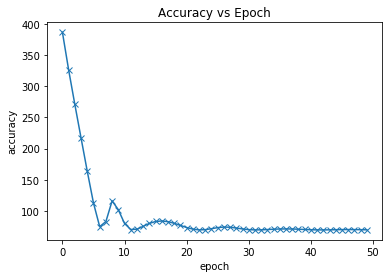

In [91]:
plt.plot(hist, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs Epoch');

In [115]:
class TimeSeriesRNNModel(nn.Module):
    def __init__(self):
        super(TimeSeriesRNNModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=5, hidden_size=50, num_layers=1)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=25, num_layers=1)
        self.linear = nn.Linear(in_features=25, out_features=1)

        self.h_t1 = None
        self.c_t1 = None
        self.h_t2 = None
        self.c_t2 = None

    def initialize_model(self, input_data):
        self.h_t1 = torch.rand(1, 1, 50, dtype=torch.double).to(device) 
        self.c_t1 = torch.rand(1, 1, 50, dtype=torch.double).to(device) 
        self.h_t2 = torch.rand(1, 1, 25, dtype=torch.double).to(device) 
        self.c_t2 = torch.rand(1, 1, 25, dtype=torch.double).to(device) 

    def forward(self, input_data):
        outputs = []
        self.initialize_model(input_data)
        
        input_data = input_data.reshape(-1, len(input_data), 5)

        output = None
        
        for _, input_t in enumerate(input_data.chunk(input_data.size(1), dim=1)):
            self.h_t1, self.c_t1 = self.lstm1(input_t, (self.h_t1, self.c_t1))
            self.h_t2, self.c_t2 = self.lstm2(self.h_t1, (self.h_t2, self.c_t2))
            output = self.linear(self.h_t2)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
# Hyper-parameters
epochs = 20
learning_rate = 1e-3
model = TimeSeriesRNNModel().to(device)

for t in model.parameters():
    print(t.shape)

In [ ]:
hist = []
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):

    #model.zero_grad()

    y_pred = model(train_tensor.to(device))

    loss = loss_fn(y_pred, target.to(device))
    
    hist.append(loss.item())

    loss.backward()

    optimizer.step()
    
    optimizer.zero_grad()
    
    #if epoch+1 % 10 == 0: 
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))